# Stop loss reinsurance pricing

## Distributional assumptions:

- externally-excited jumps: $X_i \sim \mathsf{Exp}(\alpha)$, $H(x) = 1 - \exp(-\alpha x)$ and $h(x) = \alpha \exp(\alpha x)$
- self-excited jumps: $Y_i \sim \mathsf{Exp}(\beta)$, $G(x) = 1 - \exp(-\beta x)$, $g(x) = \beta \exp(-\beta x)$
- claim sizes: $\Xi_i \sim \mathsf{Gamma}(\eta, \gamma)$, cdf $J(x)$ with pdf 
$j(x) = \frac{\gamma^\eta}{\Gamma(\eta)} x^{\eta-1} \mathrm{e}^{-\gamma x}$


These distributions all have similar Laplace transforms, e.g.
$$\hat{h}(s) = \frac{1}{1 + \frac{s}{\alpha}}, \quad \hat{g}(s) = \frac{1}{1 + \frac{s}{\beta}}, \quad \hat{j}(s) = \Bigl(1 + \frac{s}{\gamma}\Bigr)^{-\eta}. $$

In [1]:
# Set matplotlib to use retina display (higher resolution)
%config InlineBackend.figure_format = 'retina'

from functools import partial
import hashlib
import os

CACHE_DIR = "cached_samples"  # Directory for cached results
os.makedirs(CACHE_DIR, exist_ok=True)  # Ensure cache directory exists

import numpy as np
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm

from joblib import Parallel, delayed

from dynamic_contagion import *

In [ ]:
def extract_numeric_params(tilted_params):
    """
    Extracts only numerical values from tilted_params and converts arrays to hashes.

    Args:
        tilted_params: Tuple containing numerical values and functions.

    Returns:
        A tuple containing only numerical values, with arrays replaced by hash digests.
    """
    extracted = []
    for param in tilted_params:
        if isinstance(param, np.ndarray):  # Handle arrays separately
            extracted.append(
                hashlib.md5(param.tobytes()).hexdigest()
            )  # Convert array to a short hash
        elif isinstance(param, (int, float)):  # Keep scalar numbers
            extracted.append(param)
        else:
            continue  # Ignore functions and other non-numeric data
    return tuple(extracted)


def generate_filename(tilted_params, num_simulations, T, seed):
    """
    Generate a filename based on parameter values.
    Uses a hash of the parameters to create a unique identifier.
    """
    numeric_params = extract_numeric_params(tilted_params)
    param_string = f"{numeric_params}-{num_simulations}-{T}-{seed}"
    param_hash = hashlib.md5(param_string.encode()).hexdigest()  # Hashing for brevity
    return os.path.join(CACHE_DIR, f"sample_{param_hash}.npz")

In [3]:
def check_constants(alpha, beta, gamma, delta, theta, psi, nu, mu_G, j_hat_nu, B_t):
    assert theta >= 1 and psi >= 1
    assert nu < 0 and j_hat_nu > 1

    phi = - (theta * j_hat_nu - 1)
    assert phi < 0
    assert delta > theta * j_hat_nu * mu_G

    B_plus = beta - (1/delta)*theta*j_hat_nu
    assert B_plus > 0
    assert alpha >= B_plus
    assert beta >= B_plus

    assert all(B_t <= B_plus)
    assert all(delta > theta * gamma / (gamma + nu) * beta / (beta - B_t)) # Not sure about this one

In [ ]:
def ode_system(t, y, delta, rho, a, theta, psi, h_hat, g_hat, j_hat_nu):
    B = y[0]
    dydt = np.array(
        [
            delta * B - theta * j_hat_nu * (g_hat(-B) - 1),
            -a * delta * B - rho * (psi * h_hat(-B) - 1),
        ]
    )
    return dydt


def ode_jacobian(t, y, delta, rho, a, theta, psi, h_hat_prime, g_hat_prime, j_hat_nu):
    """
    Compute the Jacobian matrix of the ODE system.

    Args:
        t: Time.
        y: State vector [B, K].
        delta, rho, a, theta, psi: Parameters / tilting parameters
        h_hat_prime: Derivative of h_hat.
        g_hat_prime: Derivative of g_hat.
        j_hat_nu: Parameter j_hat_nu.

    Returns:
        Jacobian matrix (2x2).
    """
    B = y[0]

    # Compute derivatives of g_hat(-B) and h_hat(-B)
    g_prime = g_hat_prime(-B)  # g'(-B)
    h_prime = h_hat_prime(-B)  # h'(-B)

    # Jacobian elements
    df1_dB = delta + theta * j_hat_nu * g_prime
    df1_dK = 0
    df2_dB = -a * delta + rho * psi * h_prime
    df2_dK = 0

    # Construct the Jacobian matrix
    J = np.array([[df1_dB, df1_dK], [df2_dB, df2_dK]])

    # print(df1_dB)
    return J

In [ ]:
def solve_ode_system(delta, rho, a, theta, psi, h_hat, g_hat, j_hat_nu, time_grid, T):
    """
    Solve the ODE system for the given initial conditions and parameters.

    Args:
        delta, rho, a, theta: Parameters.
        h_hat: Function h_hat(s).
        g_hat: Function g_hat(s).
        j_hat_nu: Parameter j_hat_nu.
        time_grid: Time grid for the solution.

    Returns:
        Solution of the ODE system: B_t, and K_t.
    """
    # Initial conditions
    b = 0.01  # b is chosen to be small and close to zero
    B0 = b
    K0 = 0
    assert b > 0

    # Solve the ODE system
    sol = integrate.solve_ivp(
        ode_system,
        [0, T],
        np.array([B0, K0]),
        args=(delta, rho, a, theta, psi, h_hat, g_hat, j_hat_nu),
        method="BDF",  # Choose a method that supports Jacobians
        jac=ode_jacobian,
        t_eval=time_grid,
    )

    return sol.y[0, :], sol.y[1, :]

In [ ]:
def plot_ode_solution(time_grid, B_t, K_t, alpha, B_plus):
    plt.plot(time_grid, B_t, "b", label="B(t)")
    plt.plot(time_grid, K_t, "g", label="K(t)")
    plt.axhline(alpha, color="r", linestyle="--", label="alpha")
    plt.axhline(B_plus, color="m", linestyle="--", label="B_plus")
    plt.legend(loc="lower center", ncol=4)
    plt.xlabel("t")
    plt.show()

Simulating DCP after change of measure means that
$$
\tilde{\lambda}_{t} = a_t + \left( \lambda _{0}-a_t\right) e^{-\delta t}+\sum_{i \ge
1} X_{i}^{(t)} e^{-\delta \left( t - T_{1, i} \right)}\mathbb{I}_{\{ T_{1,i} \le
t \}} + \sum_{j \ge 1} Y_{j}^{(t)} e^{-\delta \left(t - T_{2,j} \right)}
\mathbb{I}_{ \{ T_{2, j} \le t \}}
$$
and noting that external Poisson $M(t)$ process is no longer homogenous with $\rho$ rate but now has rate
$$\rho_t = \psi \frac{\alpha}{\alpha - B(t)} \rho$$

In [ ]:
def tilted_parameters(
    alpha,
    beta,
    eta,
    gamma,
    delta,
    rho,
    a,
    theta,
    nu,
    psi,
    g_hat,
    h_hat,
    j_hat,
    mu_G,
    lambda_0,
    time_grid,
    T,
):
    j_hat_nu = j_hat(nu)

    B_t, _ = solve_ode_system(
        delta, rho, a, theta, psi, h_hat, g_hat, j_hat_nu, time_grid, T
    )

    check_constants(alpha, beta, gamma, delta, theta, psi, nu, mu_G, j_hat_nu, B_t)

    # F: External jump size distribution
    new_alphas = (alpha - B_t) / (
        theta * (gamma / (gamma + nu)) ** eta * (beta / (beta - B_t))
    )

    def new_ext_jump_size_dist(rg, t_index):
        return rg.exponential(scale=1 / new_alphas[t_index])

    new_mu_Hs = 1 / new_alphas

    # G: Self-excited jump size distribution
    new_betas = (beta - B_t) / (
        theta * (gamma / (gamma + nu)) ** eta * (beta / (beta - B_t))
    )

    def new_self_jump_size_dist(rg, t_index):
        return rg.exponential(scale=1 / new_betas[t_index])

    new_mu_Gs = 1 / new_betas

    # J: Catastrophe loss size distribution
    new_gamma = gamma + nu

    def new_catastrophe_loss_dist(rg, size):
        return rg.gamma(scale=1 / new_gamma, shape=eta, size=size)

    new_as = theta * j_hat_nu * g_hat(-B_t) * a
    new_rhos = psi * alpha / (alpha - B_t) * rho

    return (
        new_alphas,
        new_ext_jump_size_dist,
        new_mu_Hs,
        new_betas,
        new_self_jump_size_dist,
        new_mu_Gs,
        new_gamma,
        new_catastrophe_loss_dist,
        new_as,
        new_rhos,
        lambda_0,
        delta,
    )

In [ ]:
def sample_tilted_cdcp(seed, tilted_params, time_grid, T):

    (
        new_alphas,
        new_ext_jump_size_dist,
        new_mu_Hs,
        new_betas,
        new_self_jump_size_dist,
        new_mu_Gs,
        new_gamma,
        new_catastrophe_loss_dist,
        new_as,
        new_rhos,
        lambda_0,
        delta,
    ) = tilted_params

    rg = rnd.default_rng(seed)

    count, T1, X, T2, Y = simulate_tilted_dynamic_contagion_thinning(
        rg,
        T,
        lambda_0,
        new_as,
        new_rhos,
        delta,
        new_self_jump_size_dist,
        new_ext_jump_size_dist,
        time_grid,
    )

    losses = new_catastrophe_loss_dist(rg, count)
    C_T = np.sum(losses)
    return T1, X, T2, Y, losses, C_T

In [10]:
def sample_many_paths(tilted_params, time_grid, T, parallel = True, seed = 2025, num_simulations = 10_000, cpu=-2):
    cpu = cpu if parallel else 1

    # Check if cached file exists
    filename = generate_filename(tilted_params, num_simulations, T, seed)
    if os.path.exists(filename):
        print(f"Loading cached results from {filename}")
        npzfile = np.load(filename, allow_pickle=True)
        return np.array(npzfile["C_T"])

    print("No cached results found. Running simulations...")

    rg = np.random.default_rng(seed)
    seeds = rg.integers(0, 2**32, size=num_simulations)

    sample = partial(sample_tilted_cdcp, tilted_params=tilted_params, time_grid=time_grid, T=T)

    cdcp_sample_paths = Parallel(n_jobs=cpu)(delayed(sample)(seeds[r]) for r in range(num_simulations))

    # Unpack results
    T1, X, T2, Y, losses, C_T = zip(*cdcp_sample_paths)

    # Save results to an npz file (NumPy supports variable-length sequences)
    np.savez_compressed(
        filename, 
        T1=np.array(T1, dtype=object),
        X=np.array(X, dtype=object),
        T2=np.array(T2, dtype=object),
        Y=np.array(Y, dtype=object),
        losses=np.array(losses, dtype=object),
        C_T=np.array(C_T)
    )

    print(f"Saved results to {filename}")

    return np.array(C_T)

In [ ]:
def compute_statistics(varying_param, param_name, fixed_params, retention):
    loss_means = []
    loss_mean_ests = []
    loss_ci_ests = []
    stoploss_mean_ests = []
    stoploss_ci_ests = []

    for param_value in tqdm(varying_param):
        # Unpack fixed parameters
        (
            alpha,
            beta,
            eta,
            gamma,
            delta,
            rho,
            a,
            theta,
            nu,
            psi,
            g_hat,
            h_hat,
            j_hat,
            mu_G,
            lambda_0,
            time_grid,
            T,
        ) = fixed_params

        # Assign the varying parameter dynamically
        if param_name == "Theta":
            theta = param_value
        elif param_name == "Nu":
            nu = param_value
        elif param_name == "Psi":
            psi = param_value

        tilted_params = tilted_parameters(
            alpha,
            beta,
            eta,
            gamma,
            delta,
            rho,
            a,
            theta,
            nu,
            psi,
            g_hat,
            h_hat,
            j_hat,
            mu_G,
            lambda_0,
            time_grid,
            T,
        )

        # Sample paths
        cdcps = sample_many_paths(tilted_params, time_grid, T)
        loss_mean_ests.append(np.mean(cdcps))
        loss_ci_ests.append(np.std(cdcps) / np.sqrt(len(cdcps)) * 1.96)  # 95% CI

        # Compute stop loss
        stoploss = np.maximum(0, cdcps - retention)
        stoploss_mean_ests.append(np.mean(stoploss))
        stoploss_ci_ests.append(
            np.std(stoploss) / np.sqrt(len(stoploss)) * 1.96
        )  # 95% CI

        # Calculate the mean C_T theoretical value
        (
            new_alphas,
            new_ext_jump_size_dist,
            new_mu_Hs,
            new_betas,
            new_self_jump_size_dist,
            new_mu_Gs,
            new_gamma,
            new_catastrophe_loss_dist,
            new_as,
            new_rhos,
            lambda_0,
            delta,
        ) = tilted_params
        new_mu_J = eta / (gamma + nu)
        loss_means.append(
            tilted_C_t_expectation(
                T,
                lambda_0,
                new_mu_J,
                new_as,
                new_rhos,
                delta,
                new_mu_Gs,
                new_mu_Hs,
                time_grid,
            )
        )

    # Plot results
    plt.plot(varying_param, loss_means, label="Mean Loss")
    plt.plot(varying_param, loss_mean_ests, label="Est. Mean Loss")
    plt.plot(varying_param, stoploss_mean_ests, label="Est. Stop Loss")
    plt.xlabel(param_name)
    plt.ylabel("Expected Values")
    plt.legend()
    plt.show()

    loss_cmc = [
        f"{mean:.2f} ± {ci:.2f}" for mean, ci in zip(loss_mean_ests, loss_ci_ests)
    ]
    stoploss_cmc = [
        f"{mean:.2f} ± {ci:.2f}"
        for mean, ci in zip(stoploss_mean_ests, stoploss_ci_ests)
    ]

    # Make a dataframe with the results
    df = pd.DataFrame(
        {
            param_name: [f"{x:.2f}" for x in varying_param],
            "Mean Loss": loss_means,
            "Est. Mean Loss": loss_cmc,
            "Est. Stop Loss": stoploss_cmc,
        }
    )

    print(df.to_latex(index=False))

In [ ]:
# H: External jump size distribution
alpha = 2.0  # is relatively large
mu_H = 1 / alpha


def ext_jump_size_dist(rg):
    return rg.exponential(scale=1 / alpha)


def h_hat(s):
    return 1 / (1 + s / alpha)


h_hat_prime = lambda s: -1 / (alpha * (1 + s / alpha) ** 2)

# G: Self-excited jump size distribution
# beta = 2.0
beta = 1.0
mu_G = 1 / beta


def self_jump_size_dist(rg):
    return rg.exponential(scale=1 / beta)


def g_hat(s):
    return 1 / (1 + s / beta)


g_hat_prime = lambda s: -1 / (beta * (1 + s / beta) ** 2)


# J: Catastrophe loss size distribution
gamma = 0.4  # Rate parameter
eta = 3.0  # Shape parameter


def catastrophe_loss_dist(rg, size):
    return rg.gamma(scale=1 / gamma, shape=eta, size=size)


def j_hat(s):
    return (1 + s / gamma) ** (-eta)


# DCP parameters
# delta = 5 # DCP intensity decay rate
delta = 3  # DCP intensity decay rate
rho = 4  # DCP external Poisson process rate
# a = 0.01 # DCP long-term background rate # TODO: Try zero for a
a = 1
# lambda_0 = a + 0.1 # DCP intensity
lambda_0 = a  # DCP intensity

# Time horizon
T = 1.0
N = 5_000
time_grid = np.linspace(0, T, N)

In [ ]:
# Precompile the dcp functions
dcp_intensity(1.0, lambda_0, a, delta, [0.5, 2.0], [1.0, 3.0], [0.2, 5.0], [0.3, 6.0])
dcp_integrated_intensity(
    1.0, lambda_0, a, delta, [0.5, 2.0], [1.0, 3.0], [0.2, 5.0], [0.3, 6.0]
)
dcp_max_intensity(
    1.0, 1.0, lambda_0, a, delta, [0.5, 2.0], [1.0, 3.0], [0.2, 5.0], [0.3, 6.0]
)

In [14]:
theta = 1.25
psi = theta
nu = -0.05

In [ ]:
rg = rnd.default_rng(2025)
seeds = rg.integers(0, 2**32, size=10_000)

C_ts = np.zeros(10_000)

for r in tqdm(range(10_000)):
    count, T1, X, T2, Y = simulate_dynamic_contagion_thinning(
        rg, T, lambda_0, a, rho, delta, self_jump_size_dist, ext_jump_size_dist
    )
    losses = catastrophe_loss_dist(rg, count)
    C_ts[r] = np.sum(losses)

100%|██████████| 10000/10000 [00:01<00:00, 6729.53it/s]


In [16]:
tilted_params = tilted_parameters(alpha, beta, eta, gamma, delta, rho, a, theta, nu, psi,
            g_hat, h_hat, j_hat, mu_G, lambda_0, time_grid, T)
%time cdcps = sample_many_paths(tilted_params, time_grid, T)
np.mean(cdcps)

Loading cached results from cached_samples/sample_53f805cc09a750f291e04d68ac21ec3f.npz
CPU times: user 1.37 ms, sys: 493 μs, total: 1.86 ms
Wall time: 2.89 ms


38.15225181373347

In [ ]:
def prepare_solid_and_dashed_data(time_grid, data_series):
    """
    Creates two arrays:
    - `solid_data`: Keeps continuous/decreasing parts, removes jumps by inserting NaN.
    - `dashed_data`: Keeps only jumps, removes continuous parts by inserting NaN.

    This version does NOT use `np.diff` but instead loops over the data.
    """
    solid_data = np.copy(data_series)
    dashed_data = np.full_like(data_series, np.nan)  # Start with NaNs

    for i in range(1, len(time_grid)):
        if data_series[i] > data_series[i - 1]:  # If a jump occurs
            solid_data[i] = np.nan  # Remove the jump from solid lines
            dashed_data[i - 1] = data_series[
                i - 1
            ]  # Keep previous point in dashed line
            dashed_data[i] = data_series[i]  # Keep jump point in dashed line

    return solid_data, dashed_data


def plot_p_and_pstar(fixed_params, seed, num_simulations=100):

    (
        alpha,
        beta,
        eta,
        gamma,
        delta,
        rho,
        a,
        theta,
        nu,
        psi,
        g_hat,
        h_hat,
        j_hat,
        mu_G,
        lambda_0,
        time_grid,
        T,
    ) = fixed_params

    rg = np.random.default_rng(seed)

    # First simulate under P measure
    C_ts = np.empty((num_simulations, N))
    intensities = np.empty((num_simulations, N))

    for r in tqdm(range(num_simulations)):
        count, T1, X, T2, Y = simulate_dynamic_contagion_thinning(
            rg, T, lambda_0, a, rho, delta, self_jump_size_dist, ext_jump_size_dist
        )

        losses = catastrophe_loss_dist(rg, count)

        for t_index, t in enumerate(time_grid):
            # Count the sum of losses that correspond to T2[r] <= t
            C_ts[r, t_index] = np.sum(losses[np.array(T2) <= t])

        intensities[r] = dcp_intensities(time_grid, lambda_0, a, delta, T1, X, T2, Y)

    # Next simulate under P* measure
    (
        new_alphas,
        new_ext_jump_size_dist,
        new_mu_Hs,
        new_betas,
        new_self_jump_size_dist,
        new_mu_Gs,
        new_gamma,
        new_catastrophe_loss_dist,
        new_as,
        new_rhos,
        lambda_0,
        delta,
    ) = tilted_parameters(
        alpha,
        beta,
        eta,
        gamma,
        delta,
        rho,
        a,
        theta,
        nu,
        psi,
        g_hat,
        h_hat,
        j_hat,
        mu_G,
        lambda_0,
        time_grid,
        T,
    )

    tilted_C_ts = np.empty((num_simulations, N))
    tilted_intensities = np.empty((num_simulations, N))

    for r in tqdm(range(num_simulations)):
        count, T1, X, T2, Y = simulate_tilted_dynamic_contagion_thinning(
            rg,
            T,
            lambda_0,
            new_as,
            new_rhos,
            delta,
            new_self_jump_size_dist,
            new_ext_jump_size_dist,
            time_grid,
        )
        losses = new_catastrophe_loss_dist(rg, count)

        for t_index, t in enumerate(time_grid):
            # Count the sum of losses that correspond to T2[r] <= t
            tilted_C_ts[r, t_index] = np.sum(losses[T2 <= t])

        tilted_intensities[r] = tilted_dcp_intensities(
            0, time_grid, lambda_0, new_as, delta, T1, X, T2, Y
        )

    # Make a 2x2 plot, where LHS = P, RHS = P*, and top = C_T, bottom = Intensity
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))

    # Prepare storage for solid and dashed data
    solid_C_ts = np.empty_like(C_ts)
    dashed_C_ts = np.empty_like(C_ts)
    solid_tilted_C_ts = np.empty_like(tilted_C_ts)
    dashed_tilted_C_ts = np.empty_like(tilted_C_ts)
    solid_intensities = np.empty_like(intensities)
    dashed_intensities = np.empty_like(intensities)
    solid_tilted_intensities = np.empty_like(tilted_intensities)
    dashed_tilted_intensities = np.empty_like(tilted_intensities)

    # Process all simulations
    for r in range(num_simulations):
        solid_C_ts[r], dashed_C_ts[r] = prepare_solid_and_dashed_data(
            time_grid, C_ts[r]
        )
        solid_tilted_C_ts[r], dashed_tilted_C_ts[r] = prepare_solid_and_dashed_data(
            time_grid, tilted_C_ts[r]
        )
        solid_intensities[r], dashed_intensities[r] = prepare_solid_and_dashed_data(
            time_grid, intensities[r]
        )
        solid_tilted_intensities[r], dashed_tilted_intensities[r] = (
            prepare_solid_and_dashed_data(time_grid, tilted_intensities[r])
        )

    print(dashed_C_ts)

    # Now plot using only 2 calls per axis
    for ax, solid_data, dashed_data in zip(
        [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]],
        [solid_C_ts, solid_tilted_C_ts, solid_intensities, solid_tilted_intensities],
        [
            dashed_C_ts,
            dashed_tilted_C_ts,
            dashed_intensities,
            dashed_tilted_intensities,
        ],
    ):
        ax.plot(
            time_grid, solid_data.T, color="black", alpha=0.5, linestyle="solid"
        )  # Solid parts
        ax.plot(
            time_grid, dashed_data.T, color="black", alpha=0.5, linestyle="dashed"
        )  # Jump parts

    # axes[0, 0].set_title('P Measure')
    # axes[0, 1].set_title('P* Measure')
    axes[0, 0].set_ylabel("$C_t~~$", rotation=0, labelpad=10)
    axes[1, 0].set_ylabel("$\\lambda_t~~$", rotation=0, labelpad=10)
    axes[1, 0].set_xlabel("$t$")
    axes[1, 1].set_xlabel("$t$")
    plt.tight_layout()

100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


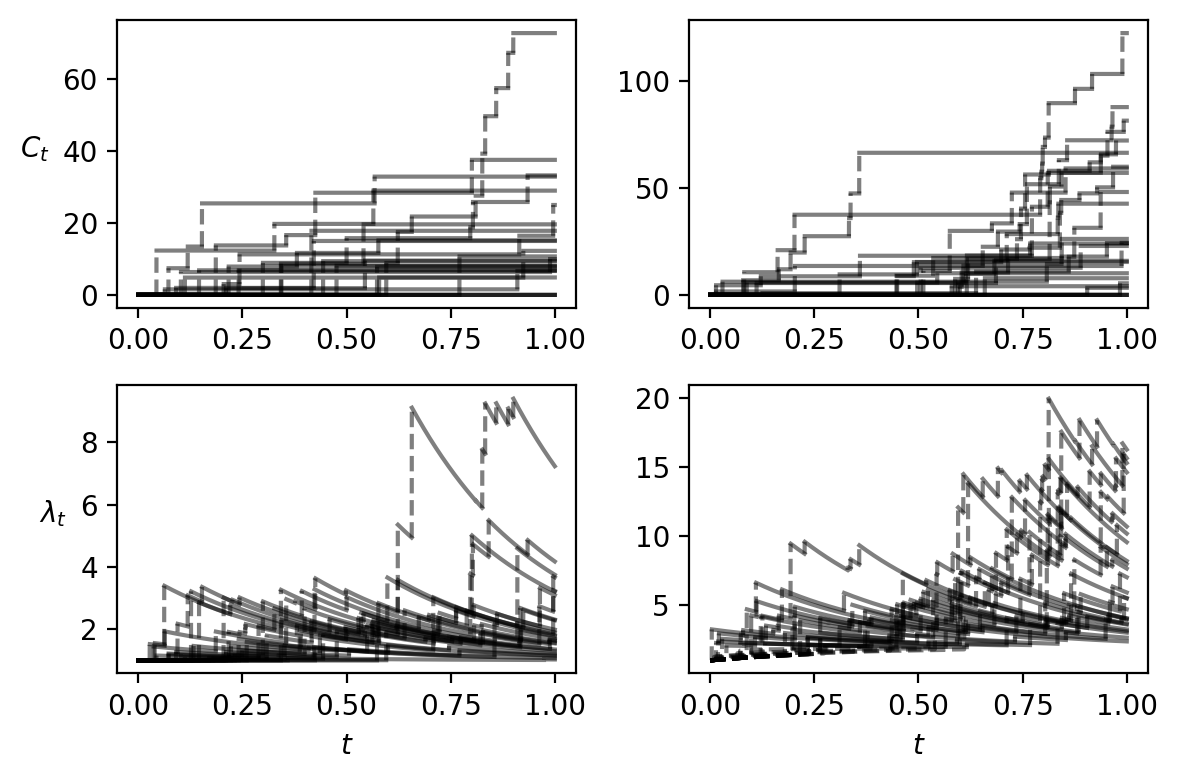

In [ ]:
default_params = (
    alpha,
    beta,
    eta,
    gamma,
    delta,
    rho,
    a,
    theta,
    nu,
    psi,
    g_hat,
    h_hat,
    j_hat,
    mu_G,
    lambda_0,
    time_grid,
    T,
)
plot_p_and_pstar(default_params, 1, 25)
plt.savefig("p_and_pstar.png", dpi=300)

In [ ]:
retention_levels = sorted([0, 25, 50, np.mean(cdcps), 75, 100])
stoplosses_p = []
stoplosses_pstar = []
for retention in retention_levels:
    stoploss = np.maximum(0, C_ts - retention)
    stoplosses_p.append(np.mean(stoploss))
    stoploss = np.maximum(0, cdcps - retention)
    stoplosses_pstar.append(np.mean(stoploss))

# Make a dataframe with retention levels and expected stop loss
df = pd.DataFrame(
    {
        "Retention": retention_levels,
        "Stop Loss (P)": stoplosses_p,
        "Stop Loss (P*)": stoplosses_pstar,
    }
)

# Change the retention level to a string with 2 decimal places
df["Retention"] = df["Retention"].apply(lambda x: f"{x:.2f}")

print(df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
Retention & Stop Loss (P) & Stop Loss (P*) \\
\midrule
0.00 & 14.041136 & 38.152252 \\
25.00 & 2.632637 & 19.153988 \\
38.15 & 1.015409 & 12.894507 \\
50.00 & 0.424692 & 8.980795 \\
75.00 & 0.070956 & 4.113723 \\
100.00 & 0.007726 & 1.859676 \\
\bottomrule
\end{tabular}



In [20]:
retention = 25

  0%|          | 0/4 [00:00<?, ?it/s]

No cached results found. Running simulations...
Saved results to cached_samples/sample_5c729270e01658aced4519a53429c2b6.npz


 25%|██▌       | 1/4 [01:05<03:17, 65.79s/it]

Loading cached results from cached_samples/sample_53f805cc09a750f291e04d68ac21ec3f.npz


 50%|█████     | 2/4 [01:06<00:55, 27.79s/it]

No cached results found. Running simulations...
Saved results to cached_samples/sample_95cfa2faaf184186d6367ff08c14c70d.npz


 75%|███████▌  | 3/4 [02:11<00:44, 44.56s/it]

No cached results found. Running simulations...
Saved results to cached_samples/sample_ac0f294931d8058fef9bc76df2c5357c.npz


100%|██████████| 4/4 [03:15<00:00, 48.90s/it]


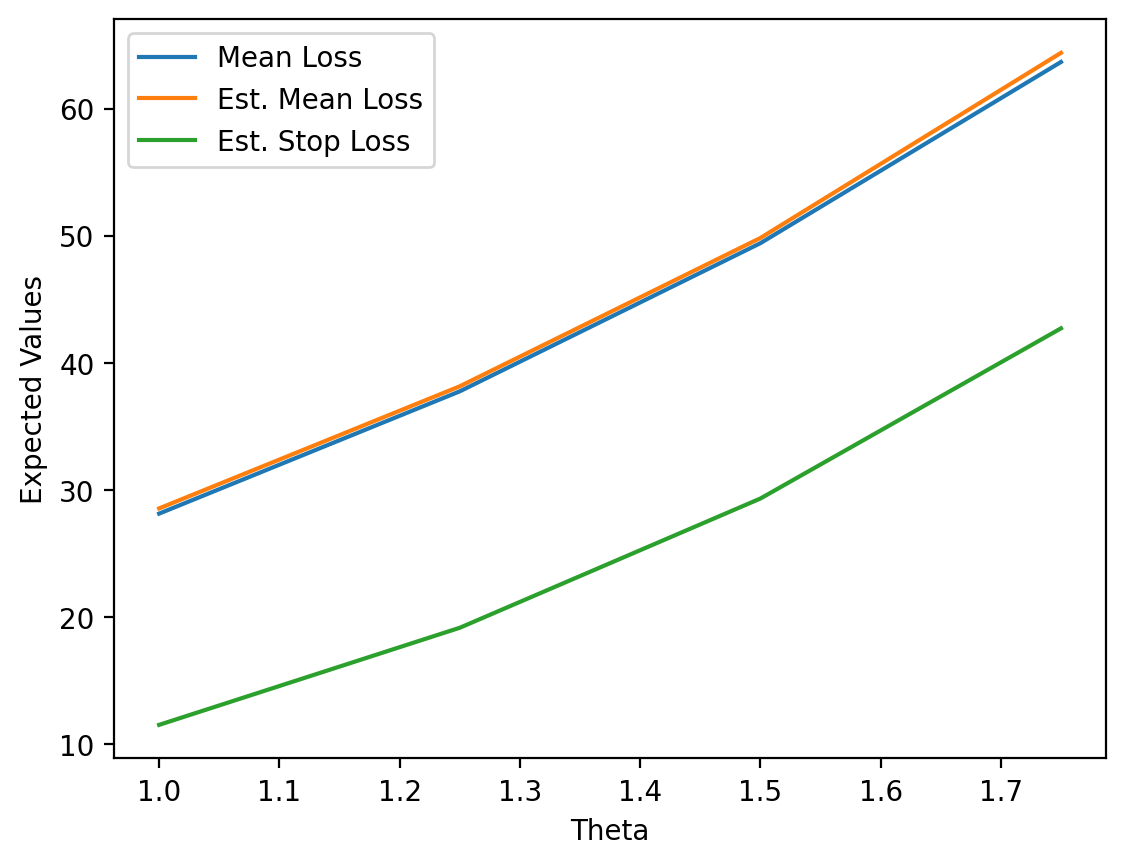

\begin{tabular}{lrll}
\toprule
Theta & Mean Loss & Est. Mean Loss & Est. Stop Loss \\
\midrule
1.00 & 28.136544 & 28.55 ± 0.52 & 11.52 ± 0.41 \\
1.25 & 37.756014 & 38.15 ± 0.68 & 19.15 ± 0.58 \\
1.50 & 49.413171 & 49.82 ± 0.87 & 29.32 ± 0.80 \\
1.75 & 63.671486 & 64.39 ± 1.11 & 42.71 ± 1.05 \\
\bottomrule
\end{tabular}

CPU times: user 21.1 s, sys: 3.32 s, total: 24.4 s
Wall time: 3min 15s


  0%|          | 0/4 [00:00<?, ?it/s]

No cached results found. Running simulations...
Saved results to cached_samples/sample_8a928ea5a90dbcf8aa26912eb3703552.npz


 25%|██▌       | 1/4 [00:56<02:49, 56.49s/it]

Loading cached results from cached_samples/sample_53f805cc09a750f291e04d68ac21ec3f.npz


 50%|█████     | 2/4 [00:57<00:47, 23.97s/it]

Loading cached results from cached_samples/sample_6f6aaffa5e08751ca80052c410ec7069.npz


 75%|███████▌  | 3/4 [00:59<00:14, 14.03s/it]

No cached results found. Running simulations...
Saved results to cached_samples/sample_6e1a16145414b0698c05dce6dc36bc08.npz


100%|██████████| 4/4 [02:18<00:00, 34.60s/it]


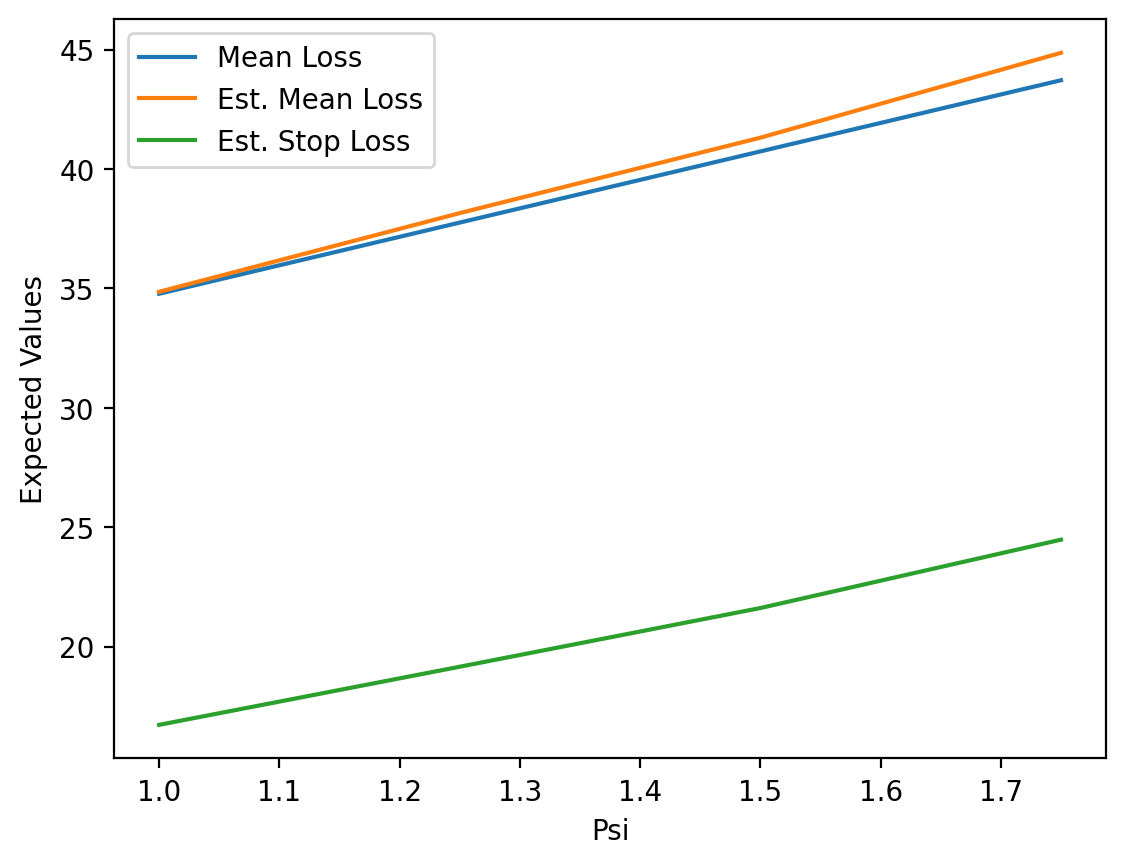

\begin{tabular}{lrll}
\toprule
Psi & Mean Loss & Est. Mean Loss & Est. Stop Loss \\
\midrule
1.00 & 34.774768 & 34.86 ± 0.65 & 16.72 ± 0.55 \\
1.25 & 37.756014 & 38.15 ± 0.68 & 19.15 ± 0.58 \\
1.50 & 40.736683 & 41.31 ± 0.71 & 21.61 ± 0.62 \\
1.75 & 43.717393 & 44.86 ± 0.74 & 24.47 ± 0.66 \\
\bottomrule
\end{tabular}

CPU times: user 20.3 s, sys: 3.33 s, total: 23.6 s
Wall time: 2min 18s


  0%|          | 0/4 [00:00<?, ?it/s]

Loading cached results from cached_samples/sample_0390b52e59f5255f9427634fa5411b63.npz


 25%|██▌       | 1/4 [00:05<00:16,  5.41s/it]

Loading cached results from cached_samples/sample_53f805cc09a750f291e04d68ac21ec3f.npz


 50%|█████     | 2/4 [00:06<00:05,  2.94s/it]

No cached results found. Running simulations...
Saved results to cached_samples/sample_3143ce458fa7d73c8bc29e6a859a5cd6.npz


 75%|███████▌  | 3/4 [01:09<00:30, 30.17s/it]

Loading cached results from cached_samples/sample_6e836ff3d3efbf81f4de369908fd989a.npz


100%|██████████| 4/4 [01:11<00:00, 17.85s/it]


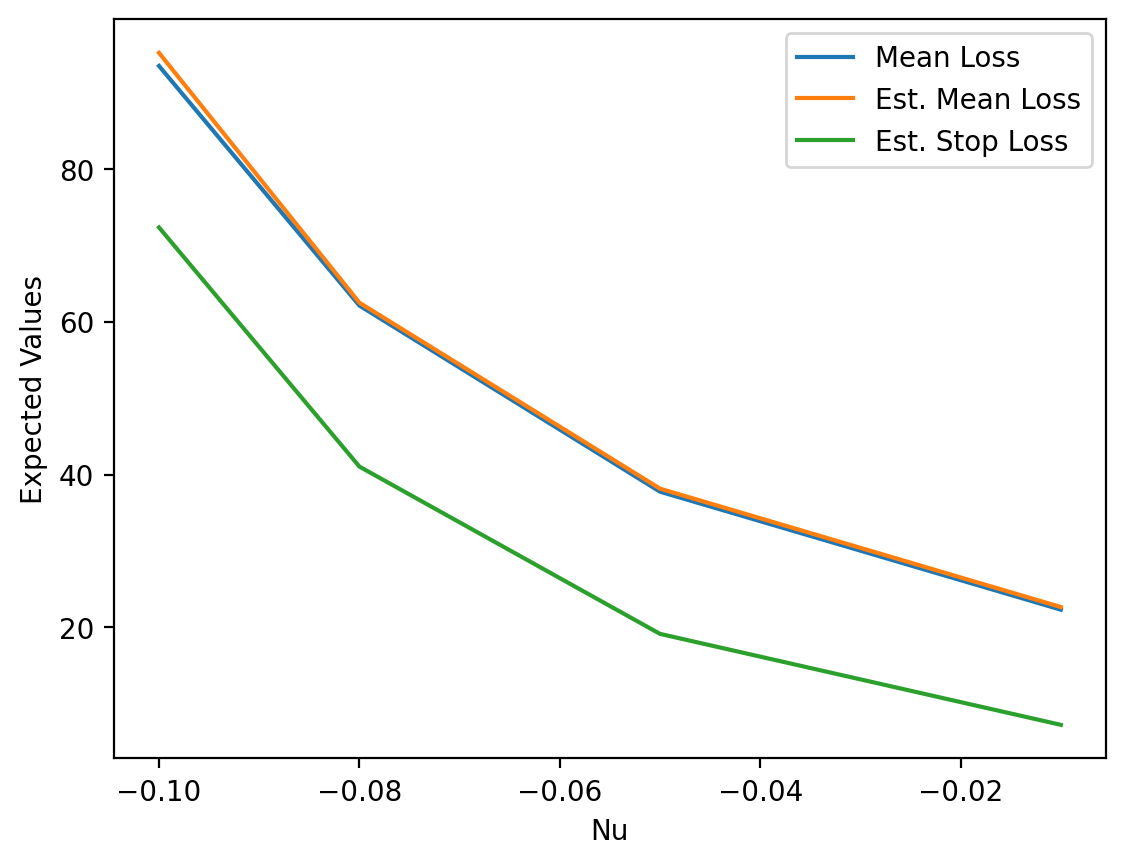

\begin{tabular}{lrll}
\toprule
Nu & Mean Loss & Est. Mean Loss & Est. Stop Loss \\
\midrule
-0.01 & 22.321852 & 22.67 ± 0.42 & 7.26 ± 0.30 \\
-0.05 & 37.756014 & 38.15 ± 0.68 & 19.15 ± 0.58 \\
-0.08 & 62.101958 & 62.48 ± 1.08 & 41.04 ± 1.02 \\
-0.10 & 93.448304 & 95.16 ± 1.67 & 72.32 ± 1.62 \\
\bottomrule
\end{tabular}

CPU times: user 10.7 s, sys: 1.08 s, total: 11.7 s
Wall time: 1min 11s


In [21]:
# Run computations for different varying parameters
default_params = (alpha, beta, eta, gamma, delta, rho, a, theta, nu, psi,
            g_hat, h_hat, j_hat, mu_G, lambda_0, time_grid, T)
%time compute_statistics([1.0, 1.25, 1.5, 1.75], 'Theta', default_params, retention)
%time compute_statistics([1.0, 1.25, 1.5, 1.75], 'Psi', default_params, retention)
%time compute_statistics([-0.01, -0.05, -0.08, -0.1], 'Nu', default_params, retention)